<a href="https://colab.research.google.com/github/himalayahall/DATA607/blob/main/Tensorflow_SMS_Categorize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

# Load libraries

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.9.2
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [2]:
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

# Load data

In [3]:
data_url = 'https://raw.githubusercontent.com/himalayahall/DATA607/main/Project4/SMSSpamCollection.txt'
df = pd.read_csv(data_url, names=["category", "sms"], skip_blank_lines=True, skiprows=1, delimiter='\t')
df.head()

,category,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Neural networks work with numeric data only. In our data set we have 2 non-numeric variables - **category** and **sms**.  

First, we mutate **category** column from categorical (string) to numeric data type. Following standard naming convention, we also change column name to **target**.  

The second column, **sms**, is not mutated (yet). Data from this column will be automatically changed using the Google **word embedding** model.

In [4]:
df['target'] = pd.Categorical(df['category'])
df['target'] = df.target.cat.codes
df = df.drop(['category'], axis=1)
df.head()

,sms,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


Define a function to create training, testing, and validation data splits. Basically, the idea if to use a subset of the data for training the classifier model,  another subset for validating the model during training, and the final subset to test the model. This is standard practice for building robust classifiers.

In [5]:
def split_train_test_val(df : pd.DataFrame, train_prop : float = 0.75, val_prop : float = 0.9):
      """
          Parameters
          ----------
          df : pd.DataFrame
              Data frame
          train_size : float
              If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. 
              If None, it will be set to 0.75. The test set will be set to it's compliment.
          val_size : float
              If float, should be between 0.0 and 1.0 and represent the proportion of the test dataset to include in the validation split. If int, represents the absolute number of validation samples. 
              If None, it will be set to 0.9.
       """
      train, test = train_test_split(df, train_size=train_prop)
      test, val = train_test_split(test, train_size = val_prop)
      print(len(train), 'train examples')
      print(len(test), 'test examples')
      print(len(val), 'validation examples')
      return train, test, val

Create train, test, validate splits.  

Extract examples and labels from each of the 3 splits.

In [6]:
train, test, val = split_train_test_val(df)

train_examples = np.array(train['sms'])
train_labels = np.array(train['target'])

test_examples = np.array(test['sms'])
test_labels = np.array(test['target'])

val_examples = np.array(val['sms'])
val_labels = np.array(val['target'])


4179 train examples
1253 test examples
140 validation examples


Validate train/test splits have similar proportion of ham (0) and spam (1) as the original data.

In [7]:
print(df.sms.count())
print(df.target.value_counts() / len(df))

splits = [train, test, val]
for s in splits:
  print(s.sms.count())
  print(s.target.value_counts() / len(s))

5572
0    0.865937
1    0.134063
Name: target, dtype: float64
4179
0    0.862886
1    0.137114
Name: target, dtype: float64
1253
0    0.878691
1    0.121309
Name: target, dtype: float64
140
0    0.842857
1    0.157143
Name: target, dtype: float64


In [8]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=False, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

Use token based text embedding model trained on English Google News 7B corpus. By using this model we avoid the need to create embeddings for the **sms** string variable. 

In [9]:
# No need to train the Google model
embedding = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2", input_shape=[], dtype=tf.string, trainable=True)

Create the Tensorflow NN model. Note, we add the Google text embedding model as the input layer.

In [10]:
model = tf.keras.Sequential()
model.add(embedding)
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 128)               6528      
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,199,209
Trainable params: 48,199,209
Non-trainable params: 0
_________________________________________________________________


Compile model.

In [11]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=[tf.metrics.BinaryAccuracy(name='accuracy')])

Train model with training data. Note, validation split is used during model training.

In [12]:
history = model.fit(train_examples,
                    train_labels,
                    epochs=5,
                     validation_data=(val_examples, val_labels)
                    )

Epoch 1/5
131/131 [==============================] - 73s 543ms/step - loss: 0.2468 - accuracy: 0.9174 - val_loss: 0.0769 - val_accuracy: 0.9929
Epoch 2/5
131/131 [==============================] - 65s 494ms/step - loss: 0.0515 - accuracy: 0.9866 - val_loss: 0.0669 - val_accuracy: 0.9857
Epoch 3/5
131/131 [==============================] - 64s 491ms/step - loss: 0.0179 - accuracy: 0.9959 - val_loss: 0.0650 - val_accuracy: 0.9786
Epoch 4/5
131/131 [==============================] - 64s 488ms/step - loss: 0.0060 - accuracy: 0.9990 - val_loss: 0.0679 - val_accuracy: 0.9857
Epoch 5/5
131/131 [==============================] - 62s 477ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.0762 - val_accuracy: 0.9857


Test the trained model against the test split.

In [13]:
loss, accuracy = model.evaluate(test_examples, test_labels)
print("Accuracy", accuracy)

40/40 [==============================] - 4s 84ms/step - loss: 0.0950 - accuracy: 0.9785
Accuracy 0.9784517288208008


In [14]:
preds = model.predict(test_examples, verbose=1)
preds_flat = [x[0] for x in preds]
preds_flat_labels = [1 if x > 0.5 else 0 for x in preds]
print(preds_flat)
print(preds_flat_labels)


40/40 [==============================] - 2s 54ms/step
[4.5816337e-06, 1.47677265e-05, 1.476967e-05, 2.9040704e-05, 2.2820015e-10, 0.0004406739, 1.4164632e-05, 0.9996796, 0.00019987125, 0.000151921, 3.6463229e-07, 2.9685864e-06, 2.5894682e-05, 1.3835935e-05, 4.9069536e-07, 2.2905238e-05, 0.00027723663, 0.0016501413, 0.002900586, 0.00027094764, 0.0009952917, 0.00036993917, 5.402371e-05, 9.698195e-08, 0.00022765597, 3.7709665e-08, 6.1556545e-07, 0.0018474745, 7.492728e-05, 6.18537e-06, 0.012826382, 3.3394375e-05, 6.32511e-06, 9.610215e-05, 7.2002217e-06, 0.071576685, 0.010336666, 0.3345055, 3.919966e-08, 4.2692356e-08, 1.0892811e-05, 0.00021901458, 0.018565305, 0.0011218138, 5.285057e-10, 0.99960035, 2.5313062e-08, 0.012867999, 0.006624383, 1.5472404e-05, 0.0012286309, 0.00013795713, 2.180824e-06, 0.00211073, 0.00012686521, 0.00019889638, 0.99986756, 0.003877269, 0.9847235, 0.99775016, 1.2778113e-05, 0.99984586, 3.600481e-05, 8.674252e-06, 0.9998718, 1.4163521e-07, 0.002034755, 0.00877494

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
target_names = ['0', '1']
cm = confusion_matrix(test_labels, preds_flat_labels)

>>> from sklearn.metrics import classification_report
>>> y_true = [0, 1, 2, 2, 2]
>>> y_pred = [0, 0, 2, 2, 1]
>>> target_names = ['class 0', 'class 1', 'class 2']
>>> print(classification_report(y_true, y_pred, target_names=target_names))

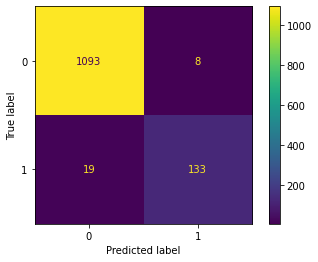

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(cm).plot()

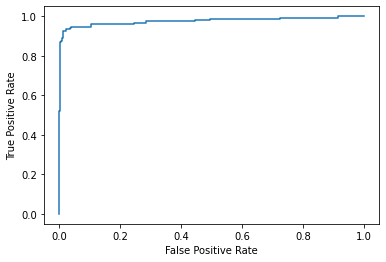

In [23]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, _ = roc_curve(test_labels, preds)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()